<a href="https://colab.research.google.com/github/Sapienza-AI-Lab/esercitazione6-22-23/blob/main/Exercise2.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

# Esercizio 2
In questo esercizio utilizzerete il dataset Heart Disease per costruire un modello in grado di predire se un paziente ha o meno una malattia cardiaca. Il dataset è composto da 303 pazienti, ognuno dei quali è descritto da 13 attributi. L'attributo target è un valore intero che va da 0 (assenza) a 4.

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Caricamento del dataset

Attributes:
* Age
* Sex:
    * Male -> 1
    * Female -> 0
* Chest Pain Type: 
    * angina -> 1
    * abnang -> 2
    * notang -> 3
    * asympt -> 4
* Resting Blood Pressure
* Cholesterol
* Fasting Blood Sugar:
    * < 120 -> 1
    * \>= 120 -> 0
* Resting ECG:
    * norm -> 0
    * abn -> 1
    * hyper -> 2
* Max Heart Rate
* Exercise Induced Angina:
    * yes -> 1
    * no -> 0
* Oldpeak
* Slope:
    * up -> 1
    * flat -> 2
    * down -> 3
* Number of vessels colored
* Thal:
    * norm -> 3
    * fixed -> 6
    * rever -> 7
* Target:
    * 0 -> no disease
    * 1,2,3,4 -> disease



In [177]:
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']
xcols = cols[0:-1]
ycol = cols[-1]
df = pd.read_csv('data/processed.cleveland.data', header=None, index_col=None, names=cols, na_values=['?'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [179]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [180]:
df = df.dropna()

In [181]:
X = df[xcols]
m, n = X.shape

# Binarize the target
y = (df[ycol] > 0).astype(int)

In [182]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
# Normalize the data
normalize = True

if normalize:
    xmean = X_train.mean()
    xstd = X_train.std()
    # Note that we use the mean and std of the training set to normalize both the training and test sets
    X_train = (X_train - xmean)/xstd
    X_test = (X_test - xmean)/xstd

### Define the model

In [184]:
# Define logistic regression model
model = LogisticRegression(solver='lbfgs', n_jobs=-1)

### Grid Search

In [185]:
# Define scorer
scorer = make_scorer(accuracy_score)

# Define grid search parameters
grid = dict()
grid['C'] = np.logspace(-6, 3, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scorer, error_score=0)

In [186]:
# Perform grid search
start = time.time()
grid_result = grid_search.fit(X_train, y_train)
end = time.time()
print('Grid search time =', end - start)

Grid search time = 1.0401570796966553


In [187]:
# Summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.822961 using {'C': 0.1}
0.523227 (0.008011) with: {'C': 1e-06}
0.523227 (0.008011) with: {'C': 1e-05}
0.523227 (0.008011) with: {'C': 0.0001}
0.801773 (0.015547) with: {'C': 0.001}
0.818617 (0.041322) with: {'C': 0.01}
0.822961 (0.057372) with: {'C': 0.1}
0.822961 (0.057372) with: {'C': 1.0}
0.818794 (0.060182) with: {'C': 10.0}
0.818794 (0.060182) with: {'C': 100.0}
0.818794 (0.060182) with: {'C': 1000.0}


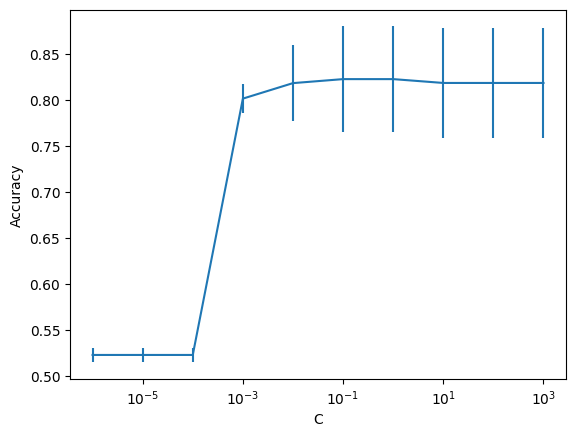

In [188]:
# Plot grid search results
plt.errorbar(grid['C'], means, yerr=stds)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [189]:
# Define logistic regression model with best parameters
model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=grid_result.best_params_['C'])

### Learning Curves

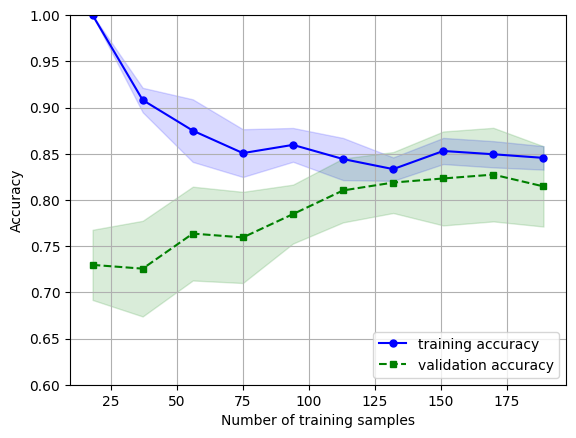

In [190]:
# Plot learning curve
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.show()

### Train

In [191]:
# Fit model on all training data
model.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1)

### Test

In [192]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy =', accuracy)

Test accuracy = 0.9


### Plot model coefficients

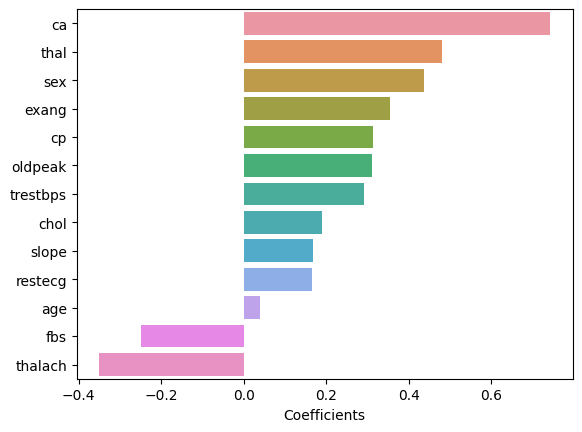

In [193]:
# Plot model coefficients
coeffs = pd.DataFrame(model.coef_, columns=xcols)
coeffs = coeffs.transpose()
coeffs.columns = ['Coefficients']
coeffs = coeffs.sort_values(by='Coefficients', ascending=False)
sns.barplot(x=coeffs['Coefficients'], y=coeffs.index)
plt.show()


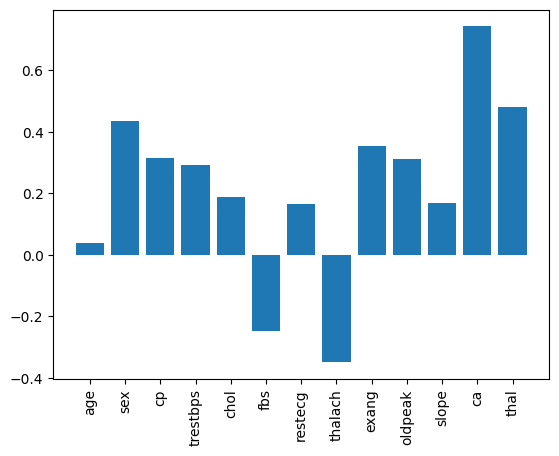

In [194]:
# Plot model coefficients without using only matplotlib
plt.bar(range(n), model.coef_[0])
plt.xticks(range(n), xcols, rotation=90)
plt.show()

# Task: Ripetete l'analisi e l'addestramento sul dataset YearPredictionMSD:

Il dataset Year Prediction MSD si puà scaricare da questo link: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

![YPMSD](data/ypmsd.jpg)
- **Nota 1:** Il dataset è molto grande. Per testare la procedura di analisi e la correttezza del codice, prima
provate su un sottoinsieme dei dati.
- **Nota 2:** Il problema può essere trattato come un problema di classificazione o di regressione. Voi iniziate a risolverlo come classificazione, poi, se volete, potete provare a risolverlo come regressione.


### Test del modello su un sottoinsieme dei dati

In [212]:
# take a porzione of the dataset

df = pd.read_csv('data/YearPredictionMSD.txt', header=None, index_col=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 91 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   int64  
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

In [197]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1997.503000,42.625028,-2.092234,10.305565,3.820842,-8.504128,-6.037830,-2.053642,-1.558934,3.544607,...,14.829205,-70.005673,44.070609,49.046268,-1.770904,13.413814,-30.816011,4.024446,10.539955,2.302654
std,13.086453,6.749215,54.364763,38.088819,18.200774,23.907766,16.943601,15.604350,8.781459,10.950480,...,31.535233,163.388074,149.354462,116.908821,17.520351,127.694684,183.331426,16.196645,179.603537,21.408361
min,1930.000000,18.982540,-242.000460,-157.365800,-70.041280,-84.550470,-55.861450,-96.656410,-36.845370,-70.918790,...,-255.607250,-1108.131750,-700.599910,-562.645010,-130.674300,-692.279400,-1699.235270,-64.538940,-1511.396930,-177.403100
25%,1993.000000,38.952395,-27.668935,-11.911933,-6.697000,-23.627070,-17.273440,-10.427238,-6.789370,-2.343380,...,-2.869117,-139.145328,-26.855182,0.820842,-9.886005,-34.619947,-100.881960,-3.207185,-60.013137,-7.731623
50%,2003.000000,43.776790,6.114735,10.373375,1.448860,-8.448555,-8.909140,-0.781325,-1.468600,3.653610,...,8.001240,-57.975785,29.149225,38.124420,-0.263795,18.543655,-27.383990,2.870160,7.672350,0.561490
75%,2006.000000,47.750655,34.574385,32.491737,11.353840,5.088590,1.987642,7.646453,3.507100,9.536840,...,25.950080,8.141525,90.703420,92.087645,6.932727,68.501762,49.385217,9.866378,75.937883,10.282497
max,2010.000000,54.009400,138.510400,233.167660,112.688390,262.068870,65.624630,111.529610,47.619120,75.038510,...,187.756660,882.096600,1106.333940,950.203750,97.774760,1125.880950,814.336930,203.649480,1099.389630,131.879180


In [213]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       515345 non-null  int64  
 1   1       515345 non-null  float64
 2   2       515345 non-null  float64
 3   3       515345 non-null  float64
 4   4       515345 non-null  float64
 5   5       515345 non-null  float64
 6   6       515345 non-null  float64
 7   7       515345 non-null  float64
 8   8       515345 non-null  float64
 9   9       515345 non-null  float64
 10  10      515345 non-null  float64
 11  11      515345 non-null  float64
 12  12      515345 non-null  float64
 13  13      515345 non-null  float64
 14  14      515345 non-null  float64
 15  15      515345 non-null  float64
 16  16      515345 non-null  float64
 17  17      515345 non-null  float64
 18  18      515345 non-null  float64
 19  19      515345 non-null  float64
 20  20      515345 non-null  float64
 21  21      51

In [214]:
df = np.array(df)
X = df[:, 1:]
m, n = X.shape

# Binarize the target
y = df[: , 0]


lista = pd.Categorical(y, ordered=True)
# convert the categorical variable to numeric
y = lista.codes

# convert the numeric to categorical variable
# lista = pd.Categorical.from_codes(y, lista.categories, ordered=True)
# y = np.array(lista)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

normalize = True
if normalize:
    xmean = X_train.mean()
    xstd = X_train.std()
    # Note that we use the mean and std of the training set to normalize both the training and test sets
    X_train = (X_train - xmean)/xstd
    X_test = (X_test - xmean)/xstd

### Define the model


In [200]:
model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=1.0, random_state=42, max_iter=1000)
scorer = make_scorer(accuracy_score)
grid = dict()
grid['C'] = np.logspace(-6, 3, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scorer, error_score=0)

In [201]:
start = time.time()
grid_result = grid_search.fit(X_train, y_train)
end = time.time()
print('Grid search time =', end - start)


/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

Grid search time = 16.024595975875854


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [202]:
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.311250 using {'C': 10.0}
0.115000 (0.003062) with: {'C': 1e-06}
0.115000 (0.003062) with: {'C': 1e-05}
0.115000 (0.003062) with: {'C': 0.0001}
0.115000 (0.017941) with: {'C': 0.001}
0.183750 (0.015104) with: {'C': 0.01}
0.243750 (0.005590) with: {'C': 0.1}
0.291250 (0.014577) with: {'C': 1.0}
0.311250 (0.015512) with: {'C': 10.0}
0.300000 (0.026220) with: {'C': 100.0}
0.283750 (0.028118) with: {'C': 1000.0}


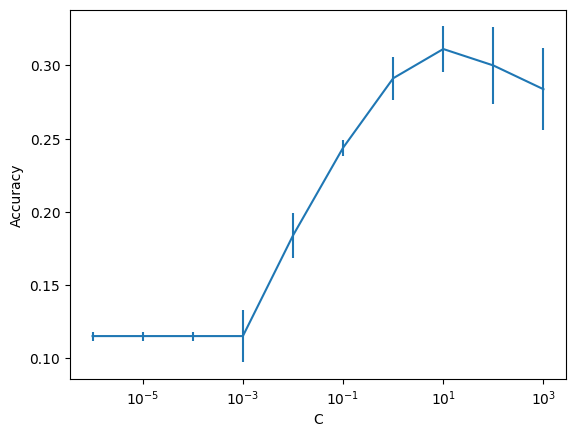

In [203]:
plt.errorbar(grid['C'], means, yerr=stds)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [215]:
model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=grid_result.best_params_['C'])

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

[0.07460051 0.07615772 0.07766642 0.07746752 0.07766642 0.07815638
 0.07764701 0.07848626 0.07849111 0.07863421]
[0.08747195 0.08387605 0.08262689 0.08200534 0.08159602 0.08122713
 0.08092813 0.0807213  0.08053214 0.08068704]


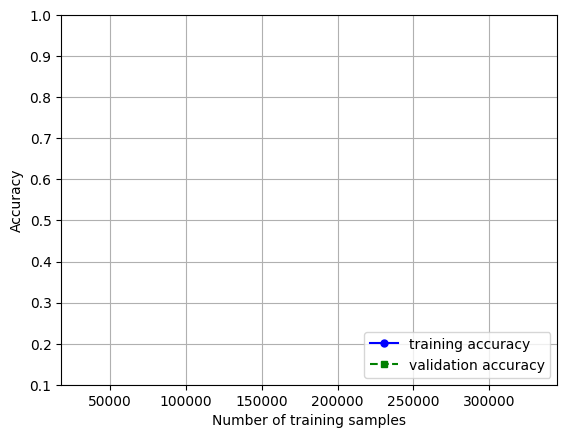

In [216]:
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(test_mean)
print(train_mean)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0001, 1.0])
plt.show()

### Train

In [217]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0, n_jobs=-1)

### Test

In [218]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy =', accuracy)

Test accuracy = 0.07837468103891568
